## 20 NG

In [167]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score as ss
from scipy.sparse import issparse
from sklearn.manifold import TSNE
import plotly.express as px
from matplotlib import pyplot as plt

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Fetch the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, train_size=0.20, stratify=newsgroups.target,random_state=42)


# Vectorize the text data into a sparse matrix without common words
max_features = 5000  # Specify the maximum number of features
stop_words = 'english'  # Specify the set of common words
count_vect = CountVectorizer(max_features=max_features, stop_words=stop_words)
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [128]:
X = X_train_tfidf


In [129]:

# Compute pairwise Euclidean distances
distances = euclidean_distances(X)

# Step 3: Applying DBSCAN on the training set
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')

labels = dbscan.fit_predict(distances)
print(labels)
# Print the number of clusters and noise points in the training set
n_train_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_train_noise = list(labels).count(-1)


print("Number of clusters in training set:", n_train_clusters)
print("Number of noise points in training set:", n_train_noise)

# Compute silhouette scores if the number of clusters is greater than 2
if len(set(labels)) > 2:
    score  = ss(X.toarray(),labels)
    print("Score:", score)



[-1 -1 -1 ... -1 -1 -1]
Number of clusters in training set: 0
Number of noise points in training set: 3769


In [130]:
import numpy as np

epsilons = np.linspace(0.01,1.5,num=15)
epsilons

array([0.01      , 0.11642857, 0.22285714, 0.32928571, 0.43571429,
       0.54214286, 0.64857143, 0.755     , 0.86142857, 0.96785714,
       1.07428571, 1.18071429, 1.28714286, 1.39357143, 1.5       ])

In [131]:
min_samples =np.arange(1,15,step=1)
min_samples

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [132]:
import itertools 

combinations = list(itertools.product(epsilons, min_samples))

In [133]:

def get_scores_and_labels(combinations, X, k=1):
    """
    Perform DBSCAN clustering using different combinations of parameters and compute silhouette scores.

    Parameters:
        combinations (list): List of tuples representing different combinations of (eps, min_samples) parameters.
        X (array-like): Input data to be clustered.
        k (int): Number of clusters desired.

    Returns:
        dict: A dictionary containing the best parameters, labels, and score.

    """

    scores = []
    all_labels_lists = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples, metric='euclidean')
        labels = dbscan_model.fit(X).labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1

        if num_clusters < 2 or num_clusters > k:
            scores.append(-10)
            all_labels_lists.append('bad')
            c = (eps, num_samples)
            print(f'combinations {c} {i + 1} of {len(combinations)} has {num_clusters} clusters. Moving on')
            continue

        all_labels_lists.append(labels)

        if issparse(X):
            score = ss(X.toarray(), labels)
        else:
            score = ss(X, labels)

        scores.append(score)
        print(f'Index: {i}, Combination: {eps}, Number of samples: {num_samples}, Scores: {scores[-1]}, Number of clusters: {num_clusters}')

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_lists[best_index]
    best_score = scores[best_index]

    return {'best_epsilon': best_parameters[0],
            'best_min_samples': best_parameters[1],
            'best_labels': best_labels,
            'best_score': best_score}


In [134]:
best_dict = get_scores_and_labels(combinations,X,20)

combinations (0.01, 1) 1 of 210 has 3767 clusters. Moving on
Index: 1, Combination: 0.01, Number of samples: 2, Scores: -0.003952446194020178, Number of clusters: 2
combinations (0.01, 3) 3 of 210 has 0 clusters. Moving on
combinations (0.01, 4) 4 of 210 has 0 clusters. Moving on
combinations (0.01, 5) 5 of 210 has 0 clusters. Moving on
combinations (0.01, 6) 6 of 210 has 0 clusters. Moving on
combinations (0.01, 7) 7 of 210 has 0 clusters. Moving on
combinations (0.01, 8) 8 of 210 has 0 clusters. Moving on
combinations (0.01, 9) 9 of 210 has 0 clusters. Moving on
combinations (0.01, 10) 10 of 210 has 0 clusters. Moving on
combinations (0.01, 11) 11 of 210 has 0 clusters. Moving on
combinations (0.01, 12) 12 of 210 has 0 clusters. Moving on
combinations (0.01, 13) 13 of 210 has 0 clusters. Moving on
combinations (0.01, 14) 14 of 210 has 0 clusters. Moving on
combinations (0.11642857142857142, 1) 15 of 210 has 3763 clusters. Moving on
Index: 15, Combination: 0.11642857142857142, Number 

In [135]:
print(best_dict)

{'best_epsilon': 0.6485714285714286, 'best_min_samples': 4, 'best_labels': array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 'best_score': 0.006154150798220846}


In [136]:
# Step 4: Apply DBSCAN
eps = best_dict['best_epsilon']
min_samples = best_dict['best_min_samples']

dbscan = DBSCAN(eps=eps, min_samples=min_samples,metric='euclidean')
dbscan.fit(X)

labels = dbscan.labels_
unique_labels,counts = np.unique(labels,return_counts=True)

# Print the label counts
for label, count in zip(unique_labels, counts):
    print("Label:", label, "Count:", count)

Label: -1 Count: 3760
Label: 0 Count: 4
Label: 1 Count: 5


In [139]:
X

<3769x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 291764 stored elements in Compressed Sparse Row format>

In [140]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

In [141]:
# Plot the t-SNE visualization
fig = px.scatter(X_tsne[:, 0], X_tsne[:, 1], color=labels)
fig.update_layout(title = "t-SNE Visualization of 20 Newsgroups Dataset")
fig.show()

### DBSCAN, as a density-based algorithm, is primarily designed for continuous numerical data, such as spatial or geographical data. It measures density based on the distances between data points. Since the 20ng dataset is text data represented as vectors, applying DBSCAN directly to the dataset may not be appropriate without appropriate data preprocessing.

## FASHION dataset

In [142]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

# Step 1: Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST',parser='auto')


In [143]:

X_train, X_test, y_train, y_test = train_test_split(fashion_mnist.data, fashion_mnist.target, test_size=0.8, stratify=fashion_mnist.target, random_state=42)

X = X_train
y = y_train

# Step 2: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [144]:
np.unique(y.values)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [145]:
X_pca.shape

(14000, 2)

In [146]:
# Plot the t-SNE visualization
fig = px.scatter(X_pca[:, 0], X_pca[:, 1], color=y.values)
fig.update_layout(title = "DBSCAN Clustering of Fashion-MNIST Dataset")
fig.show()

In [147]:
# Compute pairwise Euclidean distances
distances = euclidean_distances(X_scaled)

# Step 3: Applying DBSCAN on the training set
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')

labels = dbscan.fit_predict(distances)
print(labels)
# Print the number of clusters and noise points in the training set
n_train_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_train_noise = list(labels).count(-1)


print("Number of clusters in training set:", n_train_clusters)
print("Number of noise points in training set:", n_train_noise)

# Compute silhouette scores if the number of clusters is greater than 2
if len(set(labels)) > 2:
    score  = ss(X.toarray(),labels)
    print("Score:", score)

[-1 -1 -1 ... -1 -1 -1]
Number of clusters in training set: 0
Number of noise points in training set: 14000


### Grid search for epsilon and min sample size

In [148]:
X_train.shape

(14000, 784)

In [149]:
best_dict = get_scores_and_labels(combinations,X_scaled,10)

combinations (0.01, 1) 1 of 210 has 14000 clusters. Moving on
combinations (0.01, 2) 2 of 210 has 0 clusters. Moving on
combinations (0.01, 3) 3 of 210 has 0 clusters. Moving on
combinations (0.01, 4) 4 of 210 has 0 clusters. Moving on
combinations (0.01, 5) 5 of 210 has 0 clusters. Moving on
combinations (0.01, 6) 6 of 210 has 0 clusters. Moving on
combinations (0.01, 7) 7 of 210 has 0 clusters. Moving on
combinations (0.01, 8) 8 of 210 has 0 clusters. Moving on
combinations (0.01, 9) 9 of 210 has 0 clusters. Moving on
combinations (0.01, 10) 10 of 210 has 0 clusters. Moving on
combinations (0.01, 11) 11 of 210 has 0 clusters. Moving on
combinations (0.01, 12) 12 of 210 has 0 clusters. Moving on
combinations (0.01, 13) 13 of 210 has 0 clusters. Moving on
combinations (0.01, 14) 14 of 210 has 0 clusters. Moving on
combinations (0.11642857142857142, 1) 15 of 210 has 14000 clusters. Moving on
combinations (0.11642857142857142, 2) 16 of 210 has 0 clusters. Moving on
combinations (0.116428

In [150]:
# Find epsilon and minimum number of components on Fashion dataset pca
best_dict = get_scores_and_labels(combinations,X_pca,10)

combinations (0.01, 1) 1 of 210 has 13966 clusters. Moving on
combinations (0.01, 2) 2 of 210 has 34 clusters. Moving on
combinations (0.01, 3) 3 of 210 has 0 clusters. Moving on
combinations (0.01, 4) 4 of 210 has 0 clusters. Moving on
combinations (0.01, 5) 5 of 210 has 0 clusters. Moving on
combinations (0.01, 6) 6 of 210 has 0 clusters. Moving on
combinations (0.01, 7) 7 of 210 has 0 clusters. Moving on
combinations (0.01, 8) 8 of 210 has 0 clusters. Moving on
combinations (0.01, 9) 9 of 210 has 0 clusters. Moving on
combinations (0.01, 10) 10 of 210 has 0 clusters. Moving on
combinations (0.01, 11) 11 of 210 has 0 clusters. Moving on
combinations (0.01, 12) 12 of 210 has 0 clusters. Moving on
combinations (0.01, 13) 13 of 210 has 0 clusters. Moving on
combinations (0.01, 14) 14 of 210 has 0 clusters. Moving on
combinations (0.11642857142857142, 1) 15 of 210 has 10439 clusters. Moving on
combinations (0.11642857142857142, 2) 16 of 210 has 2031 clusters. Moving on
combinations (0.11

In [151]:
best_dict

{'best_epsilon': 1.2871428571428571,
 'best_min_samples': 8,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'best_score': 0.24653587716230102}

In [156]:
# Step 4: Apply DBSCAN
eps = best_dict['best_epsilon']
min_samples = best_dict['best_min_samples']

dbscan = DBSCAN(eps=eps, min_samples=min_samples,metric='euclidean')
dbscan.fit(X_pca)

labels = dbscan.labels_
unique_labels,counts = np.unique(labels,return_counts=True)

# Print the label counts
for label, count in zip(unique_labels, counts):
    print("Label:", label, "Count:", count)

Label: -1 Count: 182
Label: 0 Count: 13800
Label: 1 Count: 10
Label: 2 Count: 8


In [157]:
# Plot the PCA using best parameters of DBSCana 
fig = px.scatter(X_pca[:, 0], X_pca[:, 1], color=labels)
fig.update_layout(title = "Best Parmeters of DBSCAN Clustering of PCA Fashion-MNIST Dataset")
fig.show()

## Housing dataset

In [169]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Load the California housing dataset
california = fetch_california_housing()

# Create a DataFrame from the data and target variables
df = pd.DataFrame(california.data, columns=california.feature_names)
df['target'] = california.target

# Print the first few rows of the DataFrame
print(df.head())


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


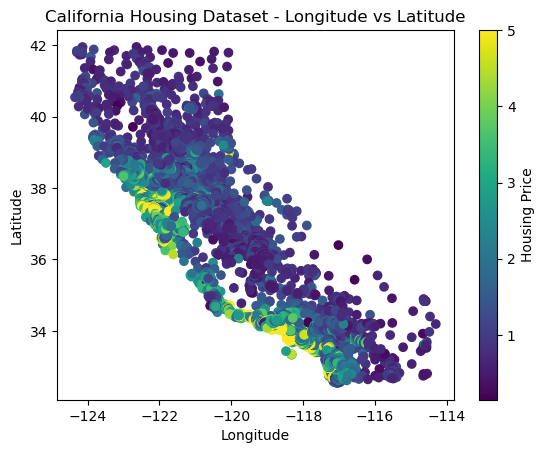

In [171]:
import matplotlib.pyplot as plt

# Plot longitude and latitude
plt.scatter(california.data[:, -1], california.data[:, -2], c=california.target)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing Dataset - Longitude vs Latitude')
plt.colorbar(label='Housing Price')
plt.show()
